In [8]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt # for making figures
%matplotlib inline

In [9]:
!wget https://raw.githubusercontent.com/karpathy/makemore/master/names.txt

# read in all the words
words = open('names.txt', 'r').read().splitlines()
words[:8]

--2024-11-24 14:57:21--  https://raw.githubusercontent.com/karpathy/makemore/master/names.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 228145 (223K) [text/plain]
Saving to: ‘names.txt’

names.txt           100%[===================>] 222.80K  --.-KB/s    in 0.004s  

2024-11-24 14:57:22 (61.6 MB/s) - ‘names.txt’ saved [228145/228145]



['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [10]:
print(len(words))

# build the vocabulary of characters and mappings to/from integers
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
print(itos)

# build the dataset
block_size = 3 # context length: how many characters do we take to predict the next one?
def build_dataset(words):
  X, Y = [], []
  for w in words:

    #print(w)
    context = [0] * block_size
    for ch in w + '.':
      ix = stoi[ch]
      X.append(context)
      Y.append(ix)
      #print(''.join(itos[i] for i in context), '--->', itos[ix])
      context = context[1:] + [ix] # crop and append

  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape, Y.shape)
  return X, Y

import random
random.seed(42)

random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])


32033
{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}
torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


In [4]:
g = torch.Generator().manual_seed(2147483647) # for reproducibility
C = torch.randn((27, 10), generator=g)
W1 = torch.randn((30, 200), generator=g)
b1 = torch.randn(200, generator=g)
W2 = torch.randn((200, 27), generator=g) * 0.01 # don't set the weights of the network to be zero, set to small,
b2 = torch.randn(27, generator=g) * 0
parameters = [C, W1, b1, W2, b2]

In [ ]:
sum(p.nelement() for p in parameters) # number of parameters in total

11897

In [ ]:
for p in parameters:
  p.requires_grad = True

In [ ]:
-torch.tensor(1/27.0).log()

tensor(3.2958)

In [ ]:
# 4d example of the issue
logits = torch.tensor([0.0,0.0,0.0,0.0])
# logits = torch.randn(4)
print(logits)
probs = torch.softmax(logits, dim=0)
loss = -probs[2].log()
probs, loss # we got the equal probab

tensor([0., 0., 0., 0.])


(tensor([0.2500, 0.2500, 0.2500, 0.2500]), tensor(1.3863))

###  fixing the initial loss

In [ ]:
lri = []
lossi = []
stepi = []

In [ ]:
max_steps = 200000
for i in range(1, max_steps):

  # minibatch construct
  ix = torch.randint(0, Xtr.shape[0], (32,))

  # forward pass
  emb = C[Xtr[ix]] # (32, 3, 10)
  h = torch.tanh(emb.view(-1, 30) @ W1 + b1) # (32, 200)
  logits = h @ W2 + b2 # (32, 27)
  loss = F.cross_entropy(logits, Ytr[ix])
  #print(loss.item())

  # backward pass
  for p in parameters:
    p.grad = None
  loss.backward()

  # update
  #lr = lrs[i]
  # lr logic in begining the lr to keep higher and lower aafter a time
  # can use learning rate decay with some factor of 10
  lr = 0.1 if i < 100000 else 0.01
  for p in parameters:
    p.data += -lr * p.grad

  # track stats
  #lri.append(lre[i])
  stepi.append(i)
  if i%10000 ==0:
    print(f'{i}/{max_steps}: {loss.item()}')
  lossi.append(loss.log10().item())
  break
#print(loss.item())

In [ ]:
print(logits[0])
# for 1st iterations

tensor([-0.0038, -0.0542,  0.2249,  0.0644,  0.0546, -0.1397,  0.1142,  0.0173,
         0.0262,  0.1714,  0.2075,  0.1270, -0.0195, -0.0081, -0.0550,  0.1045,
        -0.0639,  0.1918,  0.1270,  0.0987,  0.0951, -0.1604, -0.0076,  0.0284,
         0.0633, -0.0012,  0.0301], grad_fn=<SelectBackward0>)


In [ ]:
print(logits[0])
# for 2nd iterations


tensor([-0.1414,  0.4374, -0.1859, -0.2181, -0.2076,  0.4782, -0.0707,  0.2649,
         0.2004, -0.0846,  0.1619, -0.1128,  0.0911, -0.0701,  0.9468,  0.0538,
        -0.1283, -0.0867,  0.3645, -0.2110, -0.0906,  0.0523, -0.0662, -0.3026,
        -0.0281,  0.3238, -0.1860], grad_fn=<SelectBackward0>)


- tanh converted the distribution of full `emb.view(-1, 30) @ W1 + b1` is a noise of randome number where we introduce tanh to keep it between `(-1,1)`

(array([2149.,  141.,   90.,   84.,   54.,   44.,   39.,   27.,   16.,
          31.,   26.,   31.,   31.,   24.,   18.,   21.,   21.,   16.,
          31.,   12.,   27.,   25.,   26.,   23.,   19.,   17.,   21.,
          20.,   24.,   13.,   17.,   27.,   23.,   25.,   20.,   24.,
          21.,   13.,   26.,   37.,   25.,   36.,   34.,   42.,   51.,
          69.,   64.,  122.,  167., 2436.]),
 array([-1.  , -0.96, -0.92, -0.88, -0.84, -0.8 , -0.76, -0.72, -0.68,
        -0.64, -0.6 , -0.56, -0.52, -0.48, -0.44, -0.4 , -0.36, -0.32,
        -0.28, -0.24, -0.2 , -0.16, -0.12, -0.08, -0.04,  0.  ,  0.04,
         0.08,  0.12,  0.16,  0.2 ,  0.24,  0.28,  0.32,  0.36,  0.4 ,
         0.44,  0.48,  0.52,  0.56,  0.6 ,  0.64,  0.68,  0.72,  0.76,
         0.8 ,  0.84,  0.88,  0.92,  0.96,  1.  ]),
 <BarContainer object of 50 artists>)

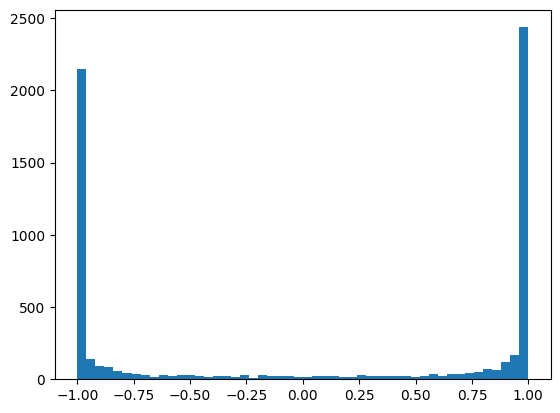

In [ ]:
plt.hist(h.view(-1).tolist(),50)
# for 1st iterations


(array([2130.,  143.,   97.,   85.,   66.,   39.,   44.,   25.,   13.,
          24.,   17.,   39.,   28.,   20.,   22.,   16.,   27.,   14.,
          18.,   24.,   23.,   35.,   22.,   21.,   17.,   13.,   15.,
          17.,   22.,   12.,   17.,   26.,   35.,   23.,   25.,   25.,
          36.,   18.,   29.,   27.,   31.,   40.,   37.,   36.,   45.,
          55.,   90.,  106.,  146., 2465.]),
 array([-1.  , -0.96, -0.92, -0.88, -0.84, -0.8 , -0.76, -0.72, -0.68,
        -0.64, -0.6 , -0.56, -0.52, -0.48, -0.44, -0.4 , -0.36, -0.32,
        -0.28, -0.24, -0.2 , -0.16, -0.12, -0.08, -0.04,  0.  ,  0.04,
         0.08,  0.12,  0.16,  0.2 ,  0.24,  0.28,  0.32,  0.36,  0.4 ,
         0.44,  0.48,  0.52,  0.56,  0.6 ,  0.64,  0.68,  0.72,  0.76,
         0.8 ,  0.84,  0.88,  0.92,  0.96,  1.  ]),
 <BarContainer object of 50 artists>)

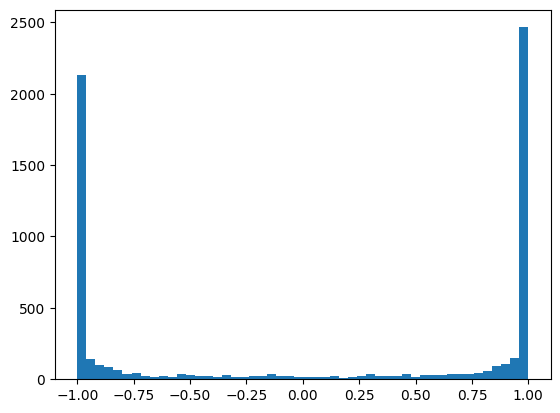

In [ ]:
plt.hist(h.view(-1).tolist(),50)
# for 2nd iterations


(array([  3.,   0.,   0.,   4.,   4.,  11.,  13.,  21.,  36.,  50.,  63.,
         65., 114., 160., 185., 228., 260., 347., 351., 356., 385., 456.,
        413., 464., 394., 375., 380., 266., 224., 171., 141., 150.,  74.,
         79.,  53.,  25.,  25.,  13.,  11.,   4.,  11.,   1.,   3.,   5.,
          1.,   2.,   0.,   1.,   1.,   1.]),
 array([-19.79801941, -18.89051044, -17.98300148, -17.07549252,
        -16.16798355, -15.26047459, -14.35296562, -13.44545666,
        -12.53794769, -11.63043873, -10.72292976,  -9.8154208 ,
         -8.90791183,  -8.00040287,  -7.09289391,  -6.18538494,
         -5.27787598,  -4.37036701,  -3.46285805,  -2.55534908,
         -1.64784012,  -0.74033115,   0.16717781,   1.07468678,
          1.98219574,   2.8897047 ,   3.79721367,   4.70472263,
          5.6122316 ,   6.51974056,   7.42724953,   8.33475849,
          9.24226746,  10.14977642,  11.05728539,  11.96479435,
         12.87230331,  13.77981228,  14.68732124,  15.59483021,
         16.502339

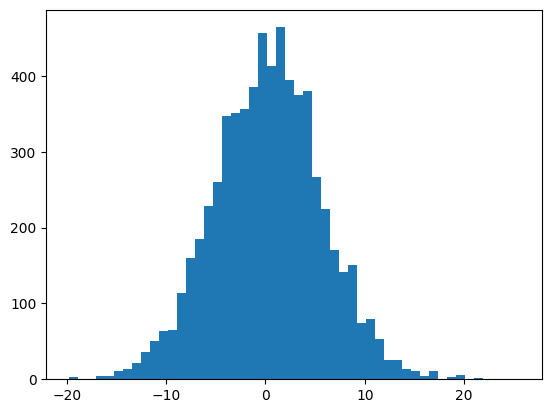

In [ ]:
plt.hist((emb.view(-1, 30) @ W1 + b1).view(-1).tolist(), 50)
# for 1st iterations

(array([  2.,   1.,   1.,   5.,   2.,   4.,   8.,  10.,  14.,  16.,  27.,
         28.,  81.,  87.,  64., 129., 173., 193., 247., 260., 296., 320.,
        353., 384., 413., 440., 402., 383., 376., 311., 295., 241., 183.,
        149., 148.,  95.,  91.,  45.,  31.,  26.,  22.,  13.,  12.,   8.,
          7.,   0.,   1.,   0.,   0.,   3.]),
 array([-21.45895958, -20.58978539, -19.72061119, -18.851437  ,
        -17.9822628 , -17.11308861, -16.24391441, -15.37474022,
        -14.50556602, -13.63639183, -12.76721764, -11.89804344,
        -11.02886925, -10.15969505,  -9.29052086,  -8.42134666,
         -7.55217247,  -6.68299828,  -5.81382408,  -4.94464989,
         -4.07547569,  -3.2063015 ,  -2.3371273 ,  -1.46795311,
         -0.59877892,   0.27039528,   1.13956947,   2.00874367,
          2.87791786,   3.74709206,   4.61626625,   5.48544044,
          6.35461464,   7.22378883,   8.09296303,   8.96213722,
          9.83131142,  10.70048561,  11.56965981,  12.438834  ,
         13.308008

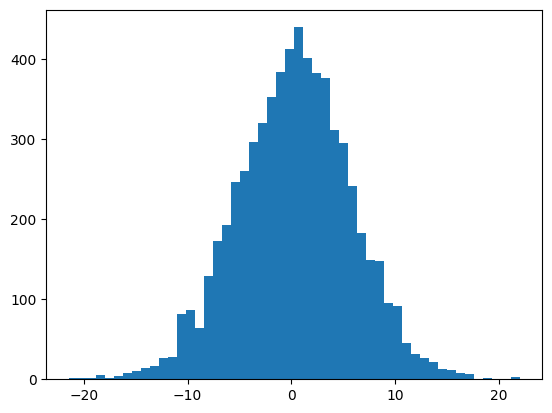

In [ ]:
plt.hist((emb.view(-1, 30) @ W1 + b1).view(-1).tolist(), 50)
# for 2nd iterations

- on second iter of tanh you see not much difference
  - on second iteration it created using backward
  - so if u see basics the grad of tanh is `self.grad = (1-t**2) * (tanh value).grad`
  - so when you see the tanh is 1 or -1 which is coverting most of the point as you can see the above plots , there the grad of tanh becomes **zero**
  - so backprop kills here
  - create the no impact on loss
  - this known by people who worked on darknets, back prop

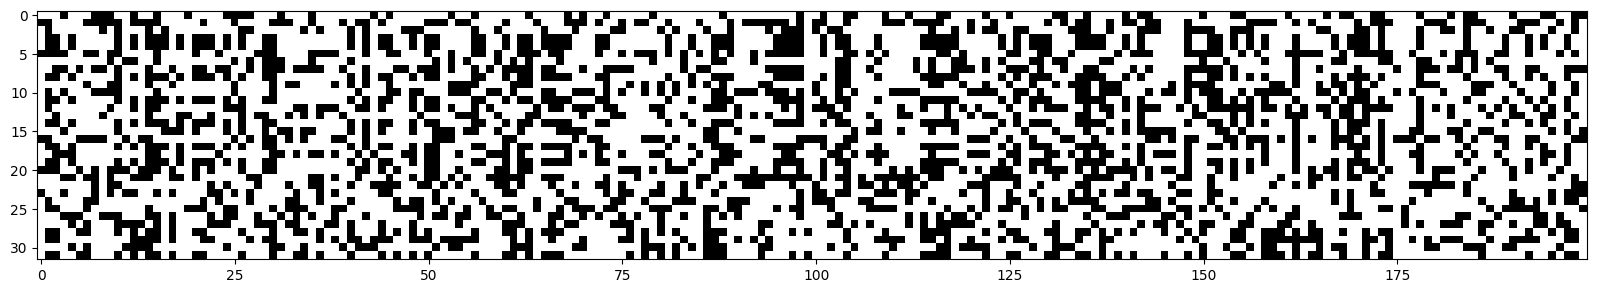

In [ ]:
plt.figure(figsize=(20,10))
plt.imshow(h.abs()>0.99, cmap='gray', interpolation='nearest')

### fixing the saturated tanh

- h.abs() provide boolearn values # white - true, black - false
- 200 neurons * 32 examples
- white are very activate as the > 0.99 so all cases backward gradient gets destroys
- these are in flat tail for all this it will get destroy
- if any case where the full 32 vertical line is white that means that **neurons is dead** .

On other non linearity function



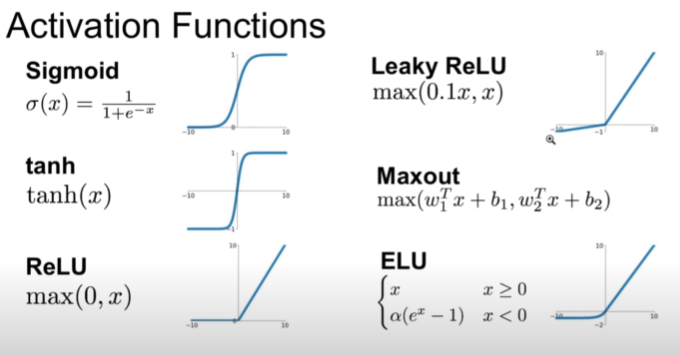

- relu produce same issue and others as it squases the nueron
- Relu have below is zero, when it increases kinda a damange in networkd whem
  - this can happend in initialization of the network
  - or can we at the optimization process when w have high Learning rate
- find nuerons which are dead,
- leaky relu not sufferes much and elu also.





In [11]:
g = torch.Generator().manual_seed(2147483647) # for reproducibility
C = torch.randn((27, 10), generator=g)
W1 = torch.randn((30, 200), generator=g) * 0.2 # * 0.1 # to deal with tanh gradient performance
b1 = torch.randn(200, generator=g) * 0.01 # to deal with tanh gradient performance
W2 = torch.randn((200, 27), generator=g) * 0.01 # don't set the weights of the network to be zero, set to small,
b2 = torch.randn(27, generator=g) * 0
parameters = [C, W1, b1, W2, b2]

In [12]:
for p in parameters:
  p.requires_grad = True

In [ ]:
lri = []
lossi = []
stepi = []

max_steps = 200000
for i in range(1, max_steps):

  # minibatch construct
  ix = torch.randint(0, Xtr.shape[0], (32,))

  # forward pass
  emb = C[Xtr[ix]] # (32, 3, 10)
  h = torch.tanh(emb.view(-1, 30) @ W1 + b1) # (32, 200)
  logits = h @ W2 + b2 # (32, 27)
  loss = F.cross_entropy(logits, Ytr[ix])
  #print(loss.item())

  # backward pass
  for p in parameters:
    p.grad = None
  loss.backward()

  # update
  #lr = lrs[i]
  # lr logic in begining the lr to keep higher and lower aafter a time
  # can use learning rate decay with some factor of 10
  lr = 0.1 if i < 100000 else 0.01
  for p in parameters:
    p.data += -lr * p.grad

  # track stats
  #lri.append(lre[i])
  stepi.append(i)
  if i%10000 ==0:
    print(f'{i}/{max_steps}: {loss.item()}')
  lossi.append(loss.log10().item())
  break
#print(loss.item())

(array([  6.,  24.,  36.,  35.,  64.,  55.,  59.,  80., 106.,  91., 122.,
        138., 150., 182., 137., 152., 173., 163., 146., 190., 183., 204.,
        162., 194., 178., 185., 200., 174., 196., 205., 188., 153., 165.,
        175., 153., 176., 182., 142., 169., 153., 130., 114., 116.,  92.,
         89.,  62.,  66.,  41.,  25.,  19.]),
 array([-9.72834945e-01, -9.33918509e-01, -8.95002074e-01, -8.56085639e-01,
        -8.17169204e-01, -7.78252769e-01, -7.39336333e-01, -7.00419898e-01,
        -6.61503463e-01, -6.22587028e-01, -5.83670592e-01, -5.44754157e-01,
        -5.05837722e-01, -4.66921287e-01, -4.28004851e-01, -3.89088416e-01,
        -3.50171981e-01, -3.11255546e-01, -2.72339110e-01, -2.33422675e-01,
        -1.94506240e-01, -1.55589805e-01, -1.16673369e-01, -7.77569342e-02,
        -3.88404989e-02,  7.59363174e-05,  3.89923716e-02,  7.79088068e-02,
         1.16825242e-01,  1.55741677e-01,  1.94658113e-01,  2.33574548e-01,
         2.72490983e-01,  3.11407418e-01,  3.50323

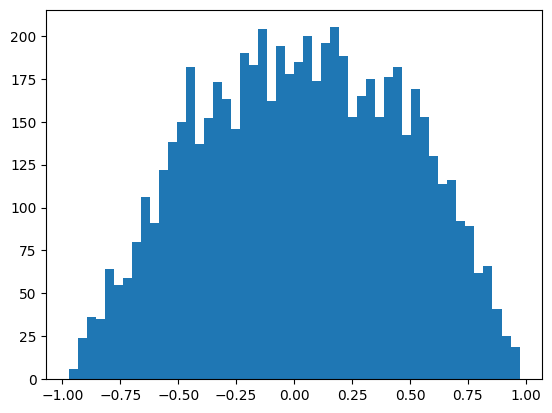

In [ ]:
plt.hist(h.view(-1).tolist(),50)
# graph improved

(array([  1.,   0.,   1.,   2.,   2.,   2.,   7.,  14.,  14.,  21.,  18.,
         32.,  57.,  55.,  69.,  92., 155., 175., 228., 302., 287., 329.,
        368., 396., 405., 426., 415., 383., 328., 322., 299., 252., 228.,
        174., 140.,  93.,  86.,  55.,  44.,  43.,  21.,  18.,  14.,   4.,
         10.,   3.,   4.,   3.,   1.,   2.]),
 array([-2.14281821e+00, -2.05704167e+00, -1.97126513e+00, -1.88548860e+00,
        -1.79971206e+00, -1.71393552e+00, -1.62815898e+00, -1.54238244e+00,
        -1.45660590e+00, -1.37082936e+00, -1.28505282e+00, -1.19927629e+00,
        -1.11349975e+00, -1.02772321e+00, -9.41946669e-01, -8.56170130e-01,
        -7.70393591e-01, -6.84617052e-01, -5.98840513e-01, -5.13063974e-01,
        -4.27287436e-01, -3.41510897e-01, -2.55734358e-01, -1.69957819e-01,
        -8.41812801e-02,  1.59525871e-03,  8.73717976e-02,  1.73148336e-01,
         2.58924875e-01,  3.44701414e-01,  4.30477953e-01,  5.16254492e-01,
         6.02031031e-01,  6.87807570e-01,  7.73584

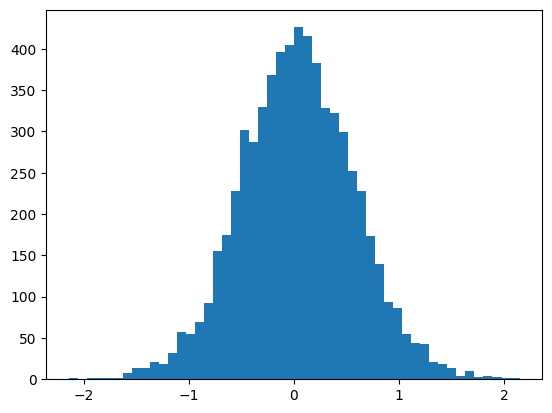

In [ ]:
plt.hist((emb.view(-1, 30) @ W1 + b1).view(-1).tolist(), 50)


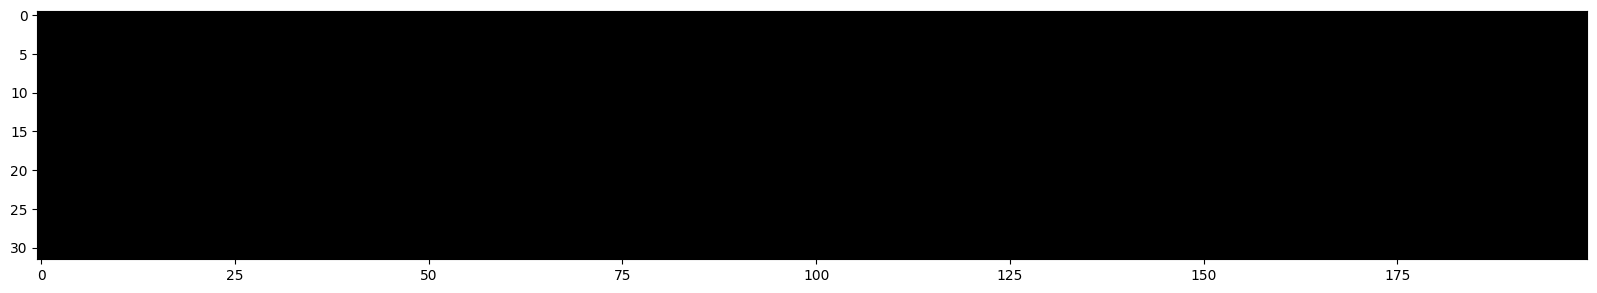

In [ ]:
plt.figure(figsize=(20,10))
plt.imshow(h.abs()>0.99, cmap='gray', interpolation='nearest')
# see all black no saturate tanh

(array([192., 170., 182., 139., 172., 154., 145., 148., 107., 112., 112.,
         98., 106.,  98., 111., 102.,  95.,  84.,  91.,  85., 105.,  95.,
         90., 124.,  83., 115.,  80., 117., 102.,  99.,  94., 114.,  94.,
        108.,  84., 131., 116., 133., 105., 122., 117., 121., 146., 169.,
        153., 189., 185., 208., 235., 263.]),
 array([-9.98693526e-01, -9.58727570e-01, -9.18761613e-01, -8.78795657e-01,
        -8.38829701e-01, -7.98863745e-01, -7.58897789e-01, -7.18931832e-01,
        -6.78965876e-01, -6.38999920e-01, -5.99033964e-01, -5.59068007e-01,
        -5.19102051e-01, -4.79136095e-01, -4.39170139e-01, -3.99204183e-01,
        -3.59238226e-01, -3.19272270e-01, -2.79306314e-01, -2.39340358e-01,
        -1.99374402e-01, -1.59408445e-01, -1.19442489e-01, -7.94765329e-02,
        -3.95105767e-02,  4.55379486e-04,  4.04213357e-02,  8.03872919e-02,
         1.20353248e-01,  1.60319204e-01,  2.00285161e-01,  2.40251117e-01,
         2.80217073e-01,  3.20183029e-01,  3.60148

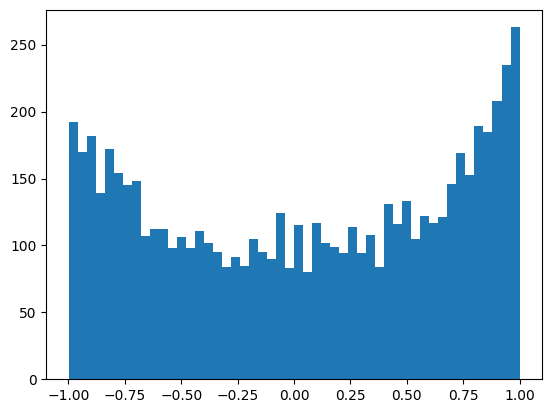

In [ ]:
plt.hist(h.view(-1).tolist(),50)
# 0.2 * with W1

(array([  3.,   1.,   3.,   9.,  17.,   9.,  20.,  18.,  23.,  45.,  46.,
         74.,  73., 144., 123., 190., 265., 259., 268., 290., 346., 350.,
        383., 400., 395., 346., 350., 304., 295., 261., 229., 190., 158.,
        117., 101.,  75.,  62.,  44.,  41.,  18.,  16.,   9.,   7.,   6.,
          9.,   2.,   1.,   1.,   0.,   4.]),
 array([-3.66711426, -3.50851587, -3.34991749, -3.1913191 , -3.03272072,
        -2.87412233, -2.71552395, -2.55692556, -2.39832718, -2.23972879,
        -2.08113041, -1.92253202, -1.76393364, -1.60533525, -1.44673687,
        -1.28813848, -1.1295401 , -0.97094172, -0.81234333, -0.65374495,
        -0.49514656, -0.33654818, -0.17794979, -0.01935141,  0.13924698,
         0.29784536,  0.45644375,  0.61504213,  0.77364052,  0.9322389 ,
         1.09083729,  1.24943567,  1.40803406,  1.56663244,  1.72523083,
         1.88382921,  2.0424276 ,  2.20102598,  2.35962437,  2.51822275,
         2.67682114,  2.83541952,  2.99401791,  3.15261629,  3.31121468,
 

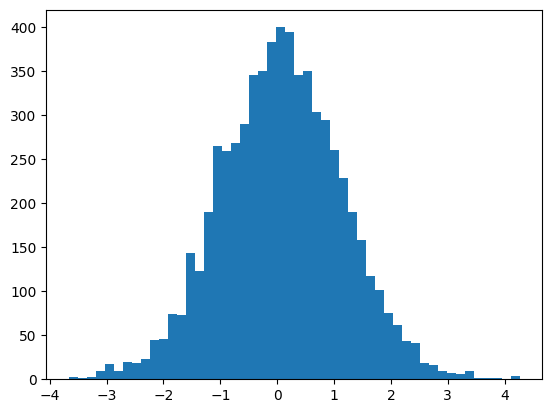

In [ ]:
plt.hist((emb.view(-1, 30) @ W1 + b1).view(-1).tolist(), 50)
# 0.2 * with W1


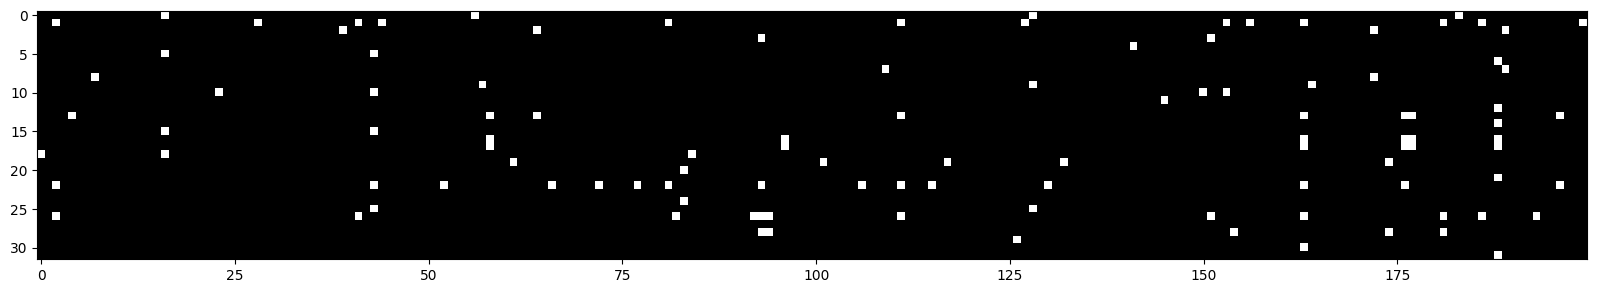

In [ ]:
plt.figure(figsize=(20,10))
plt.imshow(h.abs()>0.99, cmap='gray', interpolation='nearest')
# 0.2 * with W1
# some saturated points

### calculating the init scale: “Kaiming init”

### batch normalization

how do we provide the  * 0.2, 0.01 , etc numbers to apply to avoid the saturation problem?
- Using `kamming init` - calculated the int scale
- the paper to refer - `Delving Deep into Rectifiers: Surpassing Human-Level Performance on ImageNet Classification`  [pdf](https://arxiv.org/pdf/1502.01852)
  - [Highlights on gitHub](https://github.com/vg11072001/Machine-Learning/blob/main/ml%20notes/Theory/NN%20ZerotoHero%20Series/nn-zero-to-hero/lectures/3.1.delving%20deep%20into%20rectifiers%20to%20deal%20with%20initialization%20of%20paramaters%20on%20network.pdf)
  - Rectified Linear Unit (ReLU) and Parametric Rectified Linear Unit (PReLU)
  - ReLU, PReLU is a used here
  - in ReLU as left side (half distribution vanishes) they initialise with some gain
  - with factor of `* sqrt(2/nl)`
  - Most general way to initliaze the network:
    - 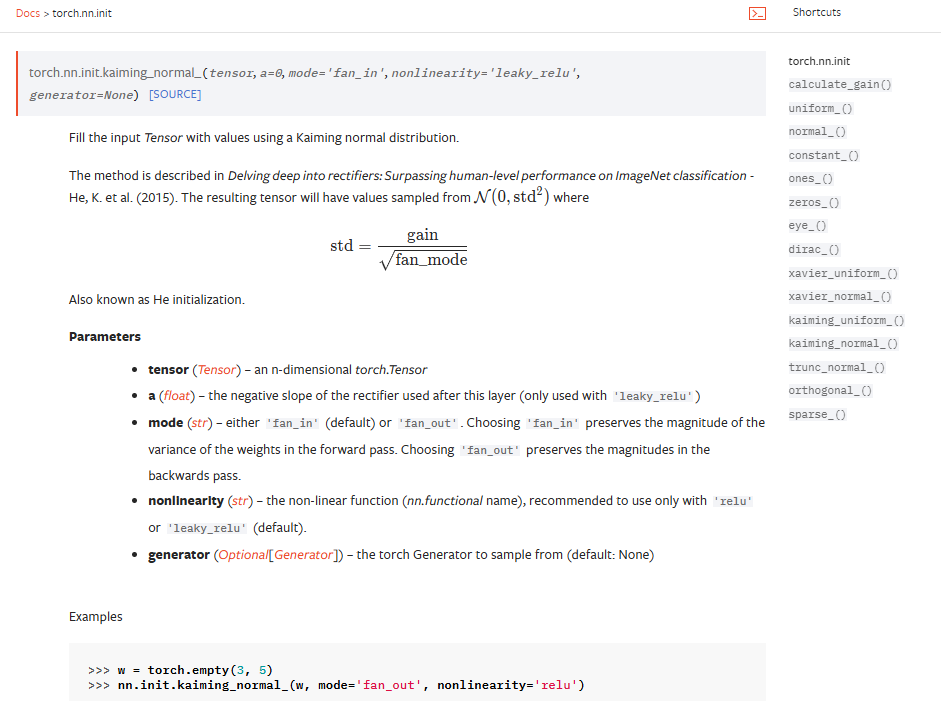
    - 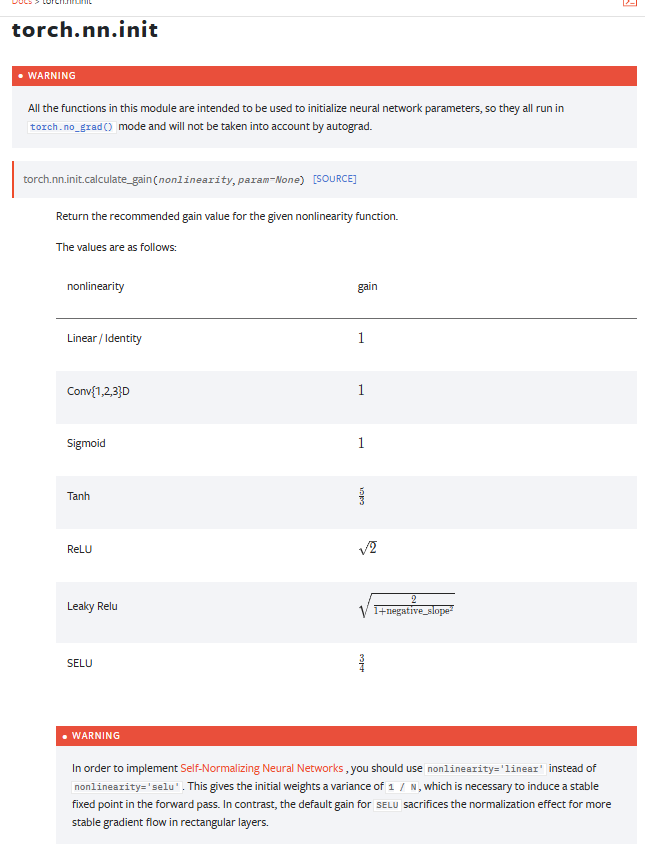
- best way to initialize the network,
  - so that in the case of mutilayer network which are very deep
  - that have the non linearity in between and
  - we want activation to be well behave not expand to the inifinity and to shink to zero

tensor(0.0026) tensor(1.0020)
tensor(-0.0131) tensor(0.3151)
tensor(0.3905) tensor(0.5895)


(array([4.01030511e+00, 4.15628329e-01, 3.99715846e-01, 3.61856347e-01,
        3.35455273e-01, 2.96266741e-01, 2.58730521e-01, 2.18141115e-01,
        1.81215532e-01, 1.49821602e-01, 1.21265339e-01, 9.76660122e-02,
        7.77305077e-02, 6.14588256e-02, 4.87791264e-02, 3.75721400e-02,
        2.89873012e-02, 2.20547744e-02, 1.57688045e-02, 1.19972225e-02,
        8.80035785e-03, 6.93252680e-03, 5.02877591e-03, 3.19686469e-03,
        1.86783105e-03, 2.08335002e-03, 1.50863277e-03, 8.97995699e-04,
        8.97995699e-04, 9.33915527e-04, 4.31037936e-04, 2.51438796e-04,
        2.15518968e-04, 1.07759484e-04, 1.79599140e-04, 7.18396559e-05,
        0.00000000e+00, 3.59198280e-05, 3.59198280e-05, 3.59198280e-05,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 3.59198280e-05]),
 array([0.        , 0.13919888, 0.27839777, 0.41759665, 0.55679554,
        0.69599442, 0.8351

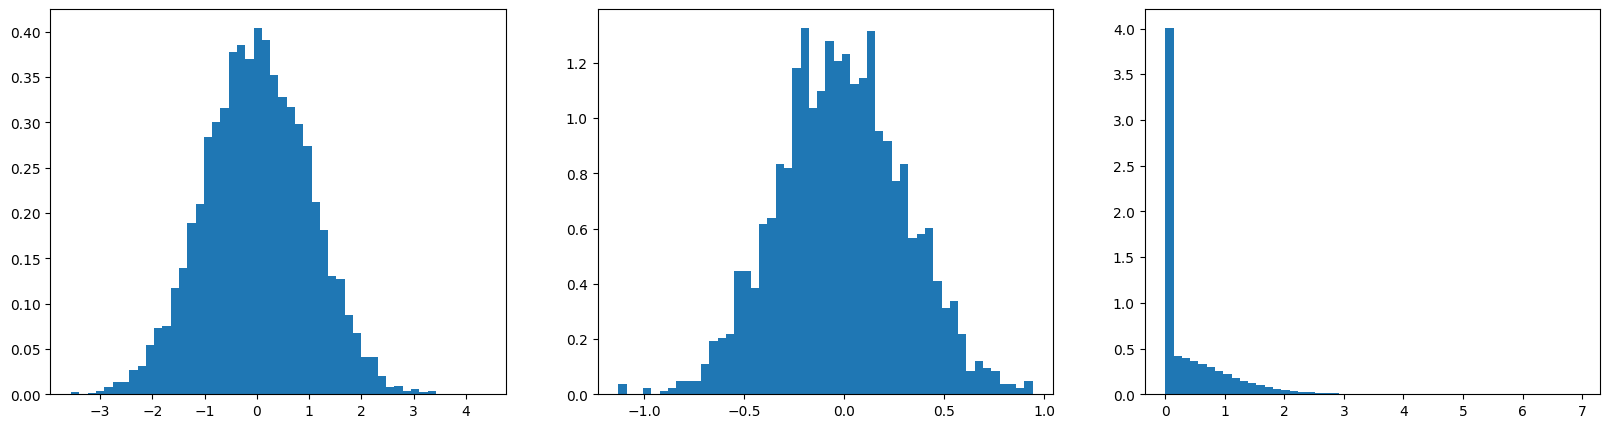

In [4]:
# example

x = torch.randn(1000, 10) # initialize using gaussian distribution
w = torch.randn(10, 200) / 10**0.5
y = torch.relu(x @ w)
print(x.mean(), x.std()) # to match the std variance in x and w the number works is dividing sqrt(fan_in) fan_in = number of parameter here
print(w.mean(), w.std()) # / 10**0.5 is sqrt(fan_in)
print(y.mean(), y.std())

plt.figure(figsize=(20,5))
plt.subplot(131)
plt.hist(x.view(-1).tolist(), 50, density= True)
plt.subplot(132)
plt.hist(w.view(-1).tolist(), 50, density= True)
plt.subplot(133)
plt.hist(y.view(-1).tolist(), 50, density= True)

- on these after the so mucnh modern technologies thing become stable like using
  - different models : RNN
  - different Normalization: Batch, Layer and Group normalization
  - different optimizser: Adam, Rspop optimizers


  - In practise just normalise weight by diving sqrt(fan_in) -  by andrej

In [6]:
(5/3)/((30)**0.5)

0.3042903097250923

In [13]:
g = torch.Generator().manual_seed(2147483647) # for reproducibility
C = torch.randn((27, 10), generator=g)
W1 = torch.randn((30, 200), generator=g) * (5/3)/((30)**0.5) # 0.2 # * 0.1 # to deal with tanh gradient performance
b1 = torch.randn(200, generator=g) * 0.01 # to deal with tanh gradient performance
W2 = torch.randn((200, 27), generator=g) * 0.01 # don't set the weights of the network to be zero, set to small,
b2 = torch.randn(27, generator=g) * 0
parameters = [C, W1, b1, W2, b2]

In [ ]:
# MLP revisited
n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 200 # the number of neurons in the hidden layer of the MLP

g = torch.Generator().manual_seed(2147483647) # for reproducibility
C  = torch.randn((vocab_size, n_embd),            generator=g)
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g) * (5/3)/((n_embd * block_size)**0.5) #* 0.2
#b1 = torch.randn(n_hidden,                        generator=g) * 0.01
W2 = torch.randn((n_hidden, vocab_size),          generator=g) * 0.01
b2 = torch.randn(vocab_size,                      generator=g) * 0

# BatchNorm parameters
bngain = torch.ones((1, n_hidden))
bnbias = torch.zeros((1, n_hidden))
bnmean_running = torch.zeros((1, n_hidden))
bnstd_running = torch.ones((1, n_hidden))

parameters = [C, W1, W2, b2, bngain, bnbias]
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
  p.requires_grad = True

In [14]:
for p in parameters:
  p.requires_grad = True

In [17]:
# same optimization as last time
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):

  # minibatch construct
  ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
  Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y

  # forward pass
  emb = C[Xb] # embed the characters into vectors
  embcat = emb.view(emb.shape[0], -1) # concatenate the vectors
  # Linear layer
  hpreact = embcat @ W1 #+ b1 # hidden layer pre-activation
  # BatchNorm layer
  # -------------------------------------------------------------
  bnmeani = hpreact.mean(0, keepdim=True)
  bnstdi = hpreact.std(0, keepdim=True)
  hpreact = bngain * (hpreact - bnmeani) / bnstdi + bnbias
  with torch.no_grad():
    bnmean_running = 0.999 * bnmean_running + 0.001 * bnmeani
    bnstd_running = 0.999 * bnstd_running + 0.001 * bnstdi
  # -------------------------------------------------------------
  # Non-linearity
  h = torch.tanh(hpreact) # hidden layer
  logits = h @ W2 + b2 # output layer
  loss = F.cross_entropy(logits, Yb) # loss function

  # backward pass
  for p in parameters:
    p.grad = None
  loss.backward()

  # update
  lr = 0.1 if i < 100000 else 0.01 # step learning rate decay
  for p in parameters:
    p.data += -lr * p.grad

  # track stats
  if i % 10000 == 0: # print every once in a while
    print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
  lossi.append(loss.log10().item())


10000/200000: 2.027735948562622
20000/200000: 2.3609163761138916
30000/200000: 2.180375814437866
40000/200000: 2.0893802642822266
50000/200000: 2.162717580795288
60000/200000: 1.8845998048782349
70000/200000: 2.196415424346924
80000/200000: 2.2004802227020264
90000/200000: 2.2909882068634033
100000/200000: 2.2884325981140137
110000/200000: 1.9317063093185425
120000/200000: 1.8180187940597534
130000/200000: 1.7678431272506714
140000/200000: 1.947242259979248
150000/200000: 2.0386435985565186
160000/200000: 2.155330181121826
170000/200000: 1.853357195854187
180000/200000: 2.3263866901397705
190000/200000: 2.013723850250244


In [18]:
@torch.no_grad() # this decorator disables gradient tracking
def split_loss(split):
  x,y = {
    'train': (Xtr, Ytr),
    'val': (Xdev, Ydev),
    'test': (Xte, Yte),
  }[split]
  emb = C[x] # (N, block_size, n_embd)
  embcat = emb.view(emb.shape[0], -1) # concat into (N, block_size * n_embd)
  hpreact = embcat @ W1 # + b1
  h = torch.tanh(hpreact) # (N, n_hidden)
  logits = h @ W2 + b2 # (N, vocab_size)
  loss = F.cross_entropy(logits, y)
  print(split, loss.item())

split_loss('train')
split_loss('val')

train 2.1471428871154785
val 2.2114412784576416


###  batch normalization: summary

- summary points:
  - this batch norm layer is coupling examples a lot, it might create issues but try to avoid now.
  - layer was very effective at controlling the statistics of the activations in the neural nut . so it was famous around 2015.
  - but now example **group normalization** or **layer normalization** and those have become more common uh in more recent deep learning


In [ ]:
# calibrate the batch norm at the end of training

with torch.no_grad():
  # pass the training set through
  emb = C[Xtr]
  embcat = emb.view(emb.shape[0], -1)
  hpreact = embcat @ W1 # + b1
  # measure the mean/std over the entire training set
  bnmean = hpreact.mean(0, keepdim=True)
  bnstd = hpreact.std(0, keepdim=True)


(array([  1.,   0.,   3.,   0.,   1.,   9.,   7.,  10.,   8.,  21.,  30.,
         56.,  61.,  69., 102., 146., 160., 214., 282., 309., 336., 379.,
        412., 396., 460., 397., 403., 337., 327., 271., 258., 204., 181.,
        149., 105.,  90.,  67.,  36.,  34.,  20.,  13.,  15.,   8.,   4.,
          3.,   2.,   1.,   1.,   0.,   2.]),
 array([-6.53965378, -6.26776182, -5.99586987, -5.72397791, -5.45208595,
        -5.180194  , -4.90830204, -4.63641008, -4.36451813, -4.09262617,
        -3.82073421, -3.54884226, -3.2769503 , -3.00505835, -2.73316639,
        -2.46127443, -2.18938248, -1.91749052, -1.64559856, -1.37370661,
        -1.10181465, -0.8299227 , -0.55803074, -0.28613878, -0.01424683,
         0.25764513,  0.52953709,  0.80142904,  1.073321  ,  1.34521296,
         1.61710491,  1.88899687,  2.16088882,  2.43278078,  2.70467274,
         2.97656469,  3.24845665,  3.52034861,  3.79224056,  4.06413252,
         4.33602448,  4.60791643,  4.87980839,  5.15170034,  5.4235923 ,
 

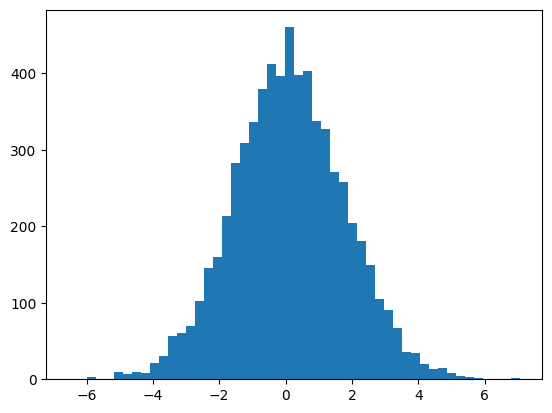

In [16]:
plt.hist((emb.view(-1, 30) @ W1 + b1).view(-1).tolist(), 50)


###  real example: resnet50 walkthrough

---

### Residual Neural Networks (ResNets)

#### Overview
1. **Definition**:
   - ResNet stands for *Residual Neural Network*, widely used for image classification tasks.
   - ResNets consist of repeating structures (blocks) stacked sequentially.

2. **Core Components**:
   - **Input Image**: Feeds into the network.
   - **Repeating Blocks**: Core building blocks replicated throughout the network.
   - **Predictions**: Output layer predicting image contents.

https://github.com/pytorch/vision/blob/main/torchvision/models/resnet.py

---

#### Bottleneck Block
1. **Definition**:
   - A bottleneck block is the fundamental unit repeated in a ResNet.
   - It is implemented as a PyTorch module.

2. **Key Features**:
   - `__init__` initializes the neural layers.
   - `forward` defines how the input propagates through the block.

3. **Structure**:
   - Components: Convolution, Batch Normalization, Non-linearity (e.g., ReLU).
   - Sequence: Convolution → Batch Normalization → Activation → Repeat.

---

#### Convolutional Layers
1. **Definition**:
   - Similar to linear layers but applied to patches instead of the full input.
   - Maintains the spatial structure of the input image.

2. **Functionality**:
   - Performs operations equivalent to \( W \cdot X + b \) on image patches.

3. **Initialization**:
   - **Keyword Parameters**:
     - `bias=False`: Disabled since Batch Normalization handles biases internally.
   - Ensures consistent weight initialization for stable training.

---

#### Batch Normalization
1. **Purpose**:
   - Normalizes activations across mini-batches.
   - Subtracts the mean and divides by the standard deviation.

2. **Integration**:
   - Reduces the need for biases in preceding layers (e.g., convolutional layers).
   - Allows efficient scaling and shifting of activations.

---

#### PyTorch Implementation
1. **Linear Layers**:
   - Performs \( W \cdot X + b \).
   - Weights are initialized based on `fan_in` and `fan_out`.

2. **Weight Initialization**:
   - Default: Uniform distribution scaled by \( 1 / \sqrt{\text{fan\_in}} \).
   - Matches the principle of maintaining stable output distributions.

3. **Convolution Layers**:
   - Similar to linear layers but applied over image patches.
   - Typically followed by Batch Normalization to manage activation dynamics.

---

#### Takeaways
1. **ResNet Design**:
   - Builds deep networks using repeating blocks with residual connections.
   - Ensures stable training with Batch Normalization and carefully initialized weights.

2. **Motif in Layers**:
   - Convolution → Batch Norm → Activation (e.g., ReLU) is the repeating sequence.

3. **PyTorch Reference**:
   - ResNet implementations are available in PyTorch, showcasing standard practices.

4. **Bias Elimination**:
   - Biases are removed in weight layers preceding Batch Normalization for efficiency.


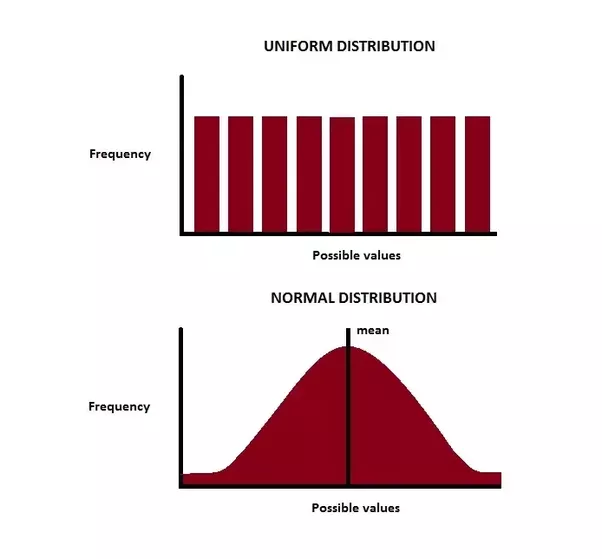

- relu used in general when deep nn

---

### just kidding: part2: PyTorch-ifying the code

Now covered:


*   pytorch-ifying:  our neural net then we will do the optimization loop as we did before
*   analyse the activation statistics on forward pass and on backward pass
* evaluation and sampling




- torch.nn
- 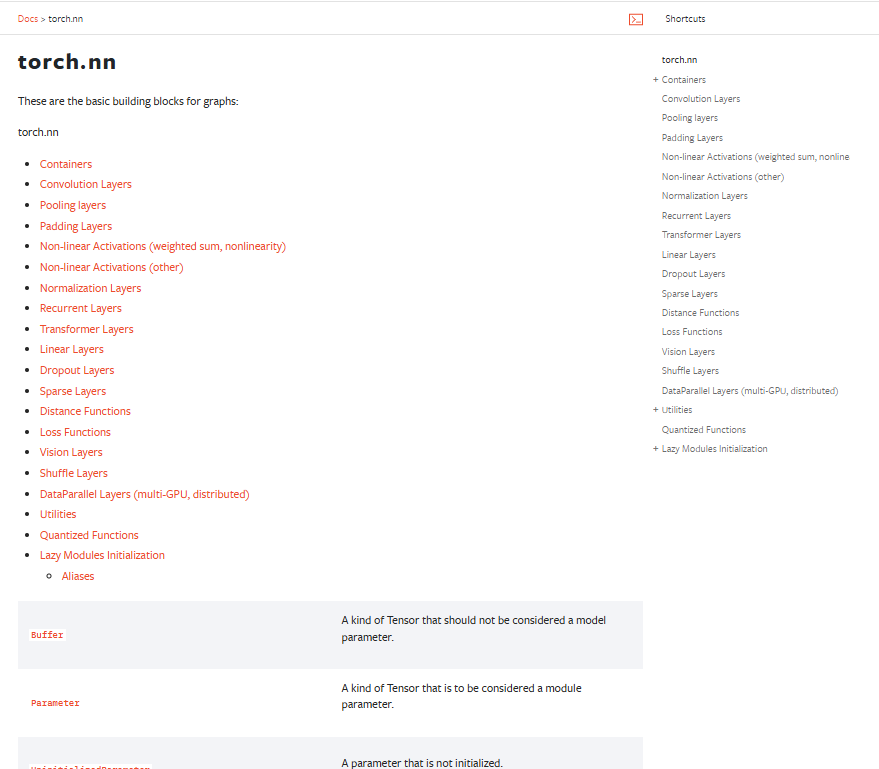

- 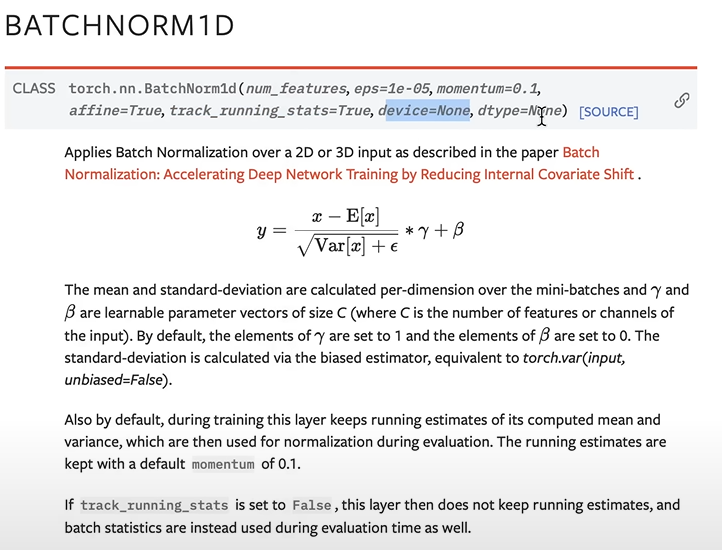

- we have mutiple layers:
  - Linear,
    - `__init__` -> weight, bias initialization
    - `__cal__` -> x@weight
    - `parameter` -> sum of parameters - bias, variance
  - BatchNorm1d,
    - `__init__` -> epos, momentum, training(to decide train, test mode), gamma, beta, running_mean, running_var
    - `__cal__` -> defines the xvariance, xmean, gamma*((x-xmean)/sqrt(xvariance + eps)+beta
    - `parameter` -> sum of parameters - gamma , beta
  - Tanh,
    - `__cal__` -> tanh(x)
    - - `parameter` -> blank

- Initialization of parameter used
  - C parameter
  - weights with 5/3 gain and output layer softmax less confident
  - 6 layers
  - for parameters grad

- Training Engine :
  - batch defined
  - forward
  - loss
  - backard
  - p.grad() added
  - lossi append for grapj

In [ ]:
# Let's train a deeper network
# The classes we create here are the same API as nn.Module in PyTorch

class Linear:

  def __init__(self, fan_in, fan_out, bias=True):
    self.weight = torch.randn((fan_in, fan_out), generator=g) / fan_in**0.5
    self.bias = torch.zeros(fan_out) if bias else None

  def __call__(self, x):
    self.out = x @ self.weight
    if self.bias is not None:
      self.out += self.bias
    return self.out

  def parameters(self):
    return [self.weight] + ([] if self.bias is None else [self.bias])


class BatchNorm1d:

  def __init__(self, dim, eps=1e-5, momentum=0.1):
    self.eps = eps
    self.momentum = momentum
    self.training = True
    # parameters (trained with backprop)
    self.gamma = torch.ones(dim)
    self.beta = torch.zeros(dim)
    # buffers (trained with a running 'momentum update')
    self.running_mean = torch.zeros(dim)
    self.running_var = torch.ones(dim)

  def __call__(self, x):
    # calculate the forward pass
    if self.training:
      xmean = x.mean(0, keepdim=True) # batch mean
      xvar = x.var(0, keepdim=True) # batch variance
    else:
      xmean = self.running_mean
      xvar = self.running_var
    xhat = (x - xmean) / torch.sqrt(xvar + self.eps) # normalize to unit variance
    self.out = self.gamma * xhat + self.beta
    # update the buffers
    if self.training:
      with torch.no_grad():
        self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * xmean
        self.running_var = (1 - self.momentum) * self.running_var + self.momentum * xvar
    return self.out

  def parameters(self):
    return [self.gamma, self.beta]

class Tanh:
  def __call__(self, x):
    self.out = torch.tanh(x)
    return self.out
  def parameters(self):
    return []

n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 100 # the number of neurons in the hidden layer of the MLP
g = torch.Generator().manual_seed(2147483647) # for reproducibility

C = torch.randn((vocab_size, n_embd),            generator=g)
layers = [
  Linear(n_embd * block_size, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  Linear(           n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  Linear(           n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  Linear(           n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  Linear(           n_hidden, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  Linear(           n_hidden, vocab_size, bias=False), BatchNorm1d(vocab_size),
]
# layers = [
#   Linear(n_embd * block_size, n_hidden), Tanh(),
#   Linear(           n_hidden, n_hidden), Tanh(),
#   Linear(           n_hidden, n_hidden), Tanh(),
#   Linear(           n_hidden, n_hidden), Tanh(),
#   Linear(           n_hidden, n_hidden), Tanh(),
#   Linear(           n_hidden, vocab_size),
# ]

with torch.no_grad():
  # last layer: make less confident
  layers[-1].gamma *= 0.1
  #layers[-1].weight *= 0.1
  # all other layers: apply gain
  for layer in layers[:-1]:
    if isinstance(layer, Linear):
      layer.weight *= 1.0 #5/3

parameters = [C] + [p for layer in layers for p in layer.parameters()]
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
  p.requires_grad = True

In [ ]:
# same optimization as last time
max_steps = 200000
batch_size = 32
lossi = []
ud = []

for i in range(max_steps):

  # minibatch construct
  ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
  Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y

  # forward pass
  emb = C[Xb] # embed the characters into vectors
  x = emb.view(emb.shape[0], -1) # concatenate the vectors
  for layer in layers:
    x = layer(x)
  loss = F.cross_entropy(x, Yb) # loss function

  # backward pass
  for layer in layers:
    layer.out.retain_grad() # AFTER_DEBUG: would take out retain_graph
  for p in parameters:
    p.grad = None
  loss.backward()

  # update
  lr = 0.1 if i < 150000 else 0.01 # step learning rate decay
  for p in parameters:
    p.data += -lr * p.grad

  # track stats
  if i % 10000 == 0: # print every once in a while
    print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
  lossi.append(loss.log10().item())
  with torch.no_grad():
    ud.append([((lr*p.grad).std() / p.data.std()).log10().item() for p in parameters])

  if i >= 1000:
    break # AFTER_DEBUG: would take out obviously to run full optimization

### viz #2: backward pass gradient statistics

- Histogram of the forwayd pass activations on Tanh layer except (last layer) softmaxx layer
- TanH has finite output -1 to 1
- early to visualise
  - std()
  - mean()
  - staurated % :  (t.abs()> 0.97).mean()*100 -> tails of tanh - > that means it stops gradients
  - with gain of 1:
  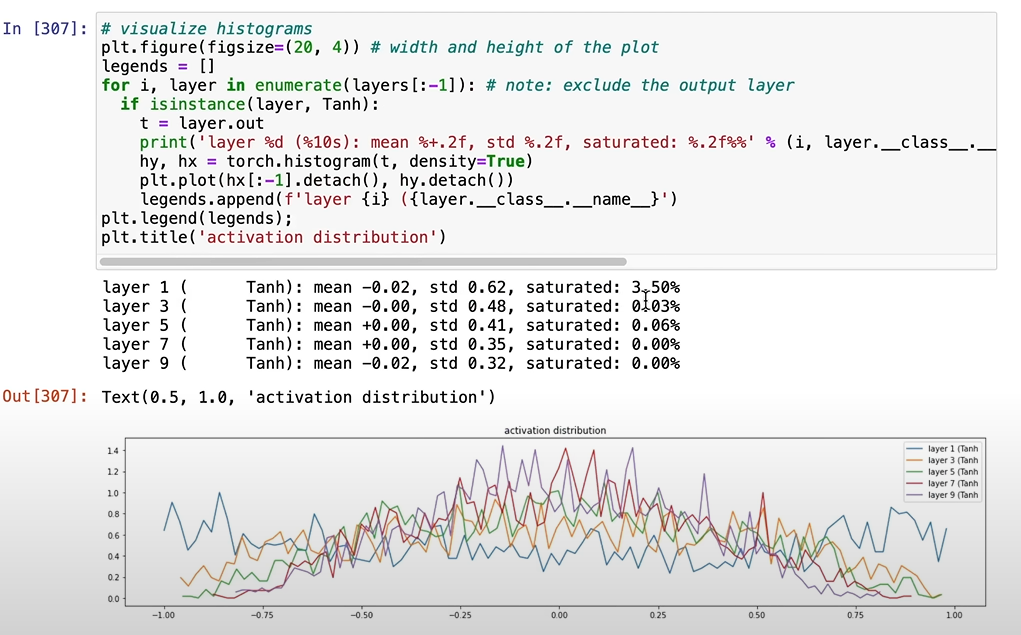
  - With gain of 5/3
  - 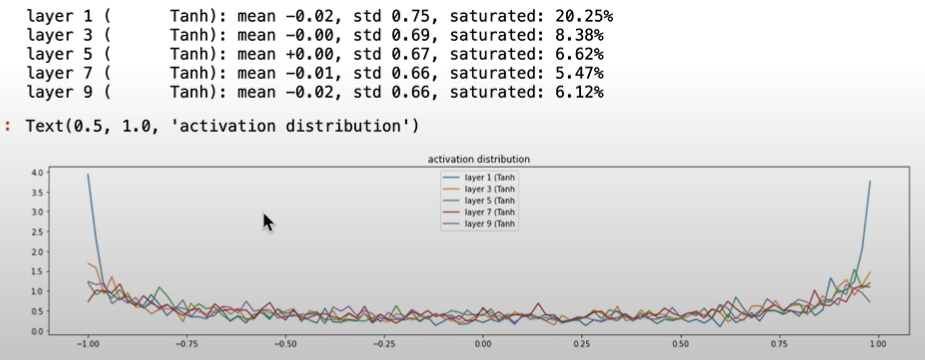


- 3 as gain
- 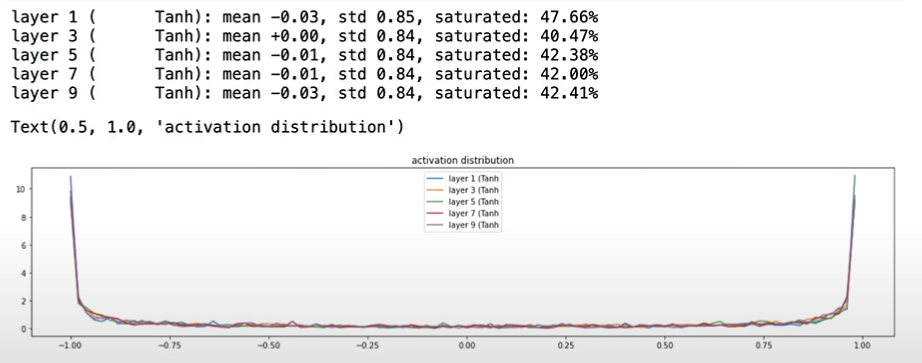


- previously would have conserved the standard deviation of one
- but because we have this interspersed 10 in layers in there these tanh layers are squashing functions
- and so they take your distribution and they slightly squash it
- and so some gain is necessary to keep expanding it to fight the squashing so it just turns out that `5/3` is a good value

- so if we have something too small like `1` we saw that
- `2` then here we see that um well let me do something a bit more extreme
- `3` saturations are going to be way too large okay so three would create way too saturated activations

so `5/3` is a good setting for a sandwich of linear layers with tanh activations

- Gradient of layers analysis:
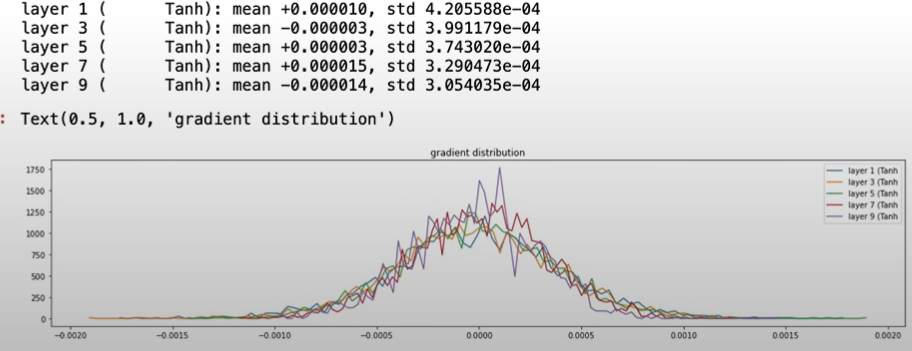

- all the different layers in this sandwich has roughly the same gradient things are not shrinking or exploding so
- for 0.5 gain: check the grad and activation gradient:
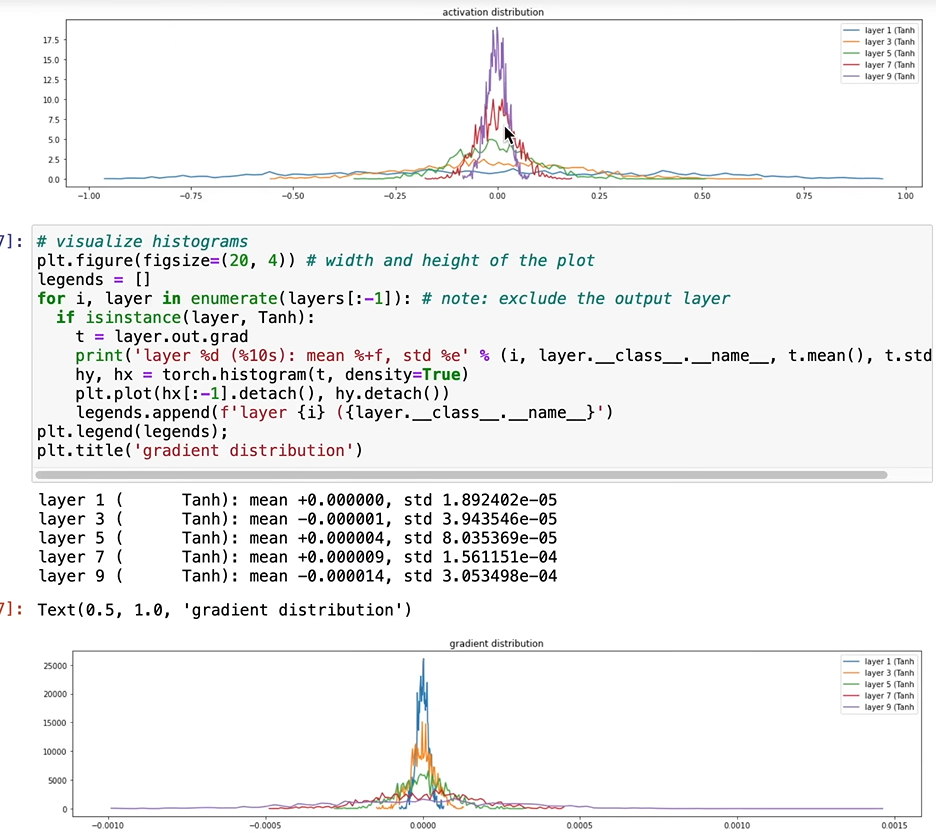

- good activation needed for forward and backward pass

- without Tanh layer, on analysing the Linear layers
- 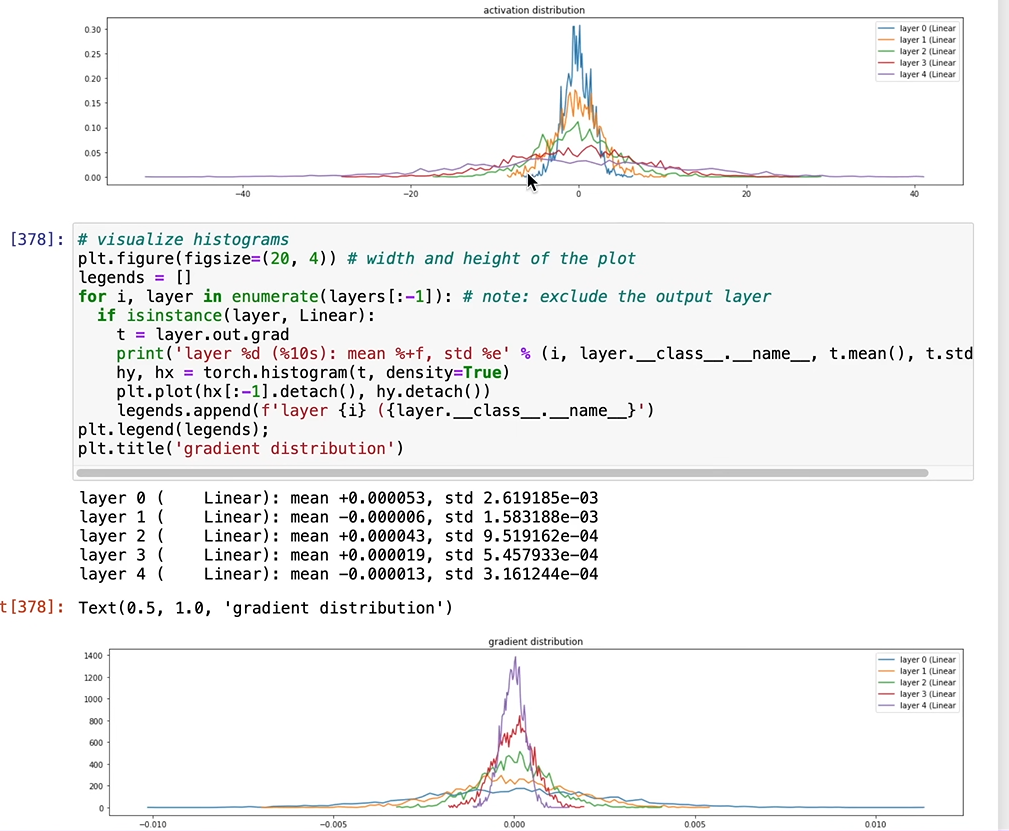



above mentioned is for 0.5 gain

- without tanh layer the best gain will be `1`.
- here the initialization is very important

### the fully linear case of no non-linearities

Why Do We Need Tanh Layers in Neural Networks?

1. Non-linearity for Function Approximation:

  - A stack of linear layers collapses to a single linear transformation, limiting the network to learning only linear functions, regardless of its depth.
  - Adding non-linear activation functions like tanh transforms the network into a universal approximator capable of modeling complex, non-linear relationships in data.

2. Enhanced Training Dynamics:

  - While the forward pass of stacked linear layers results in a simple linear transformation, the backward pass during training exhibits unique optimization dynamics.
  - Including tanh layers introduces non-linearities, enabling the network to learn richer representations and improving its ability to generalize effectively.

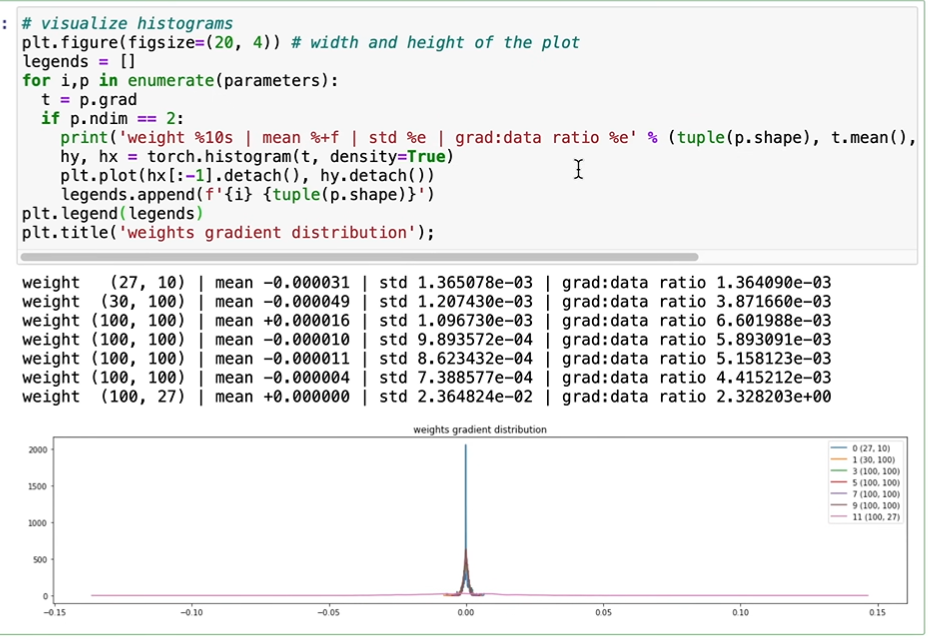

- `p.ndime == 2:` All the parameters of 2 dimensions, ie weights and bias
- other params gammas, betas
- 3 parts considered `mean, std, t.std()/p.std()`:
    - gradient to parameter data ratio = scale of the gradient compared to the scale of the actual values
    - this is important
      - step update um that is the learning rate times the gradient onto the data
      - so if the gradient has too large of magnitude if the numbers in there are too large compared to the numbers in data
      - then you'd be in trouble but in this case the gradient to data is our low numbers so the values inside grad are 1,000 times smaller than the values inside data in these weights most of them .

- Issues with the Last Layer in Neural Networks
1. Gradient Discrepancy:

The gradients of the last layer are often significantly larger (e.g., 10 times greater) than the gradients of earlier layers. This leads to the last layer being trained much faster than the preceding layers, causing imbalanced updates during training, especially when using simple optimizers like **stochastic gradient descent (SGD).**

2. Optimization Challenges:

The last layer can exhibit saturation or instability during the forward and backward passes, with neurons potentially shrinking to zero or exploding to infinity. While optimization (e.g., after 1,000 steps) may stabilize the weights, this issue complicates the early stages of training.

3. Modern Optimizers Help:

Advanced optimizers like **Adam** help mitigate these challenges by adapting learning rates for individual parameters, ensuring more balanced updates across all layers, including the troublesome last layer.

###  viz #3: parameter activation and gradient statistics

- more important part is **update to values in tensor ratio**,
  - `lr*p.grad.std
  ()/p.data.std
  ()`

Key Insights on the Update-to-Data Ratio in Neural Network Training
1. Purpose of the Update-to-Data Ratio:

The update-to-data ratio quantifies how much the parameter updates (scaled by the learning rate and gradient) affect the current values of the parameters.
It helps assess whether the updates are too large (overwhelming the current parameter values) or too small (leading to slow training).
2. Visualization and Stabilization:

By plotting the log10 of the update-to-data ratio over time, you can observe how updates evolve during training. Ideal ratios stabilize around -3 (1/1000 of parameter magnitude), ensuring balanced updates.
3. Impact of Miscalibrated Learning Rates:

High learning rates result in ratios above -3, indicating excessively large updates, which can destabilize training.
Low learning rates lead to ratios below -3, implying updates are too small, slowing down learning.
4. Last Layer Anomalies:

The last layer often shows outlier behavior initially due to specific initialization (e.g., scaling weights by 0.1 for softmax confidence). However, ratios typically stabilize as training progresses.
5. Practical Use:

Monitoring the update-to-data ratio provides an additional method for adjusting learning rates and ensuring effective training dynamics.
This approach complements other metrics like loss curves and gradient magnitudes, helping refine hyperparameter settings for optimal performance.







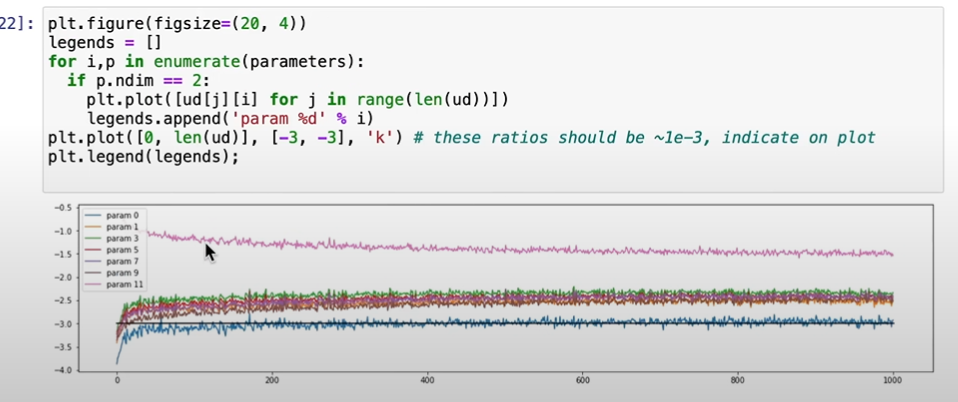

Key Takeaways on Calibration Issues and Batch Normalization in Neural Networks
1. Signs of Miscalibration:

- Activations: Neurons become saturated, indicating poor flow of gradients.
- Gradients: Become erratic, with extreme values or asymmetry.
- Parameter Updates: Show discrepancies, with some layers learning much faster than others. The update-to-data ratio can exceed acceptable bounds (e.g., > -3), disrupting stability.
- Weight Histograms: Exhibit irregular distributions, with imbalances or asymmetry across layers.
2. Fan-In Normalization:

- Proper weight initialization using techniques like fan-in normalization ensures that gradients and activations remain stable across layers.
- Forgetting this normalization leads to significant training instability, evidenced by plots and metrics.
3. Challenges with Precise Calibration:

Even with careful tuning (e.g., initializing gains), maintaining balanced gradients, activations, and updates feels precarious, akin to "balancing a pencil on your finger."
4. Batch Normalization to the Rescue:

Placement: Typically inserted after a linear layer but before the nonlinearity. Placement after the nonlinearity or at the output layer is also viable, depending on the architecture.
- **Effect**:
  - Ensures consistent activation distributions with a standard deviation around ~0.65.
  - Homogenizes gradients across layers, avoiding extremes.
  - Stabilizes parameter updates, keeping update-to-data ratios close to ideal values (around -3).
- **Softmax Layer Adjustment**: For the last layer, instead of modifying weights, BatchNorm adjusts the gamma parameter, ensuring confidence calibration while maintaining stability.
5. Advantages of Batch Normalization:

- Simplifies tuning of weight initialization and learning rates.
Promotes faster convergence by maintaining stable gradients and activations.
- Acts as a safeguard against miscalibrations that might arise due to improper initialization or challenging training dynamics.


In summary, while manual calibration using fan-in normalization can achieve well-behaved training, batch normalization automates this process, providing robustness and simplicity in stabilizing deep neural networks.

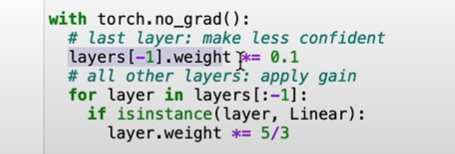

- if lr is 0.001
- then we are getting
- 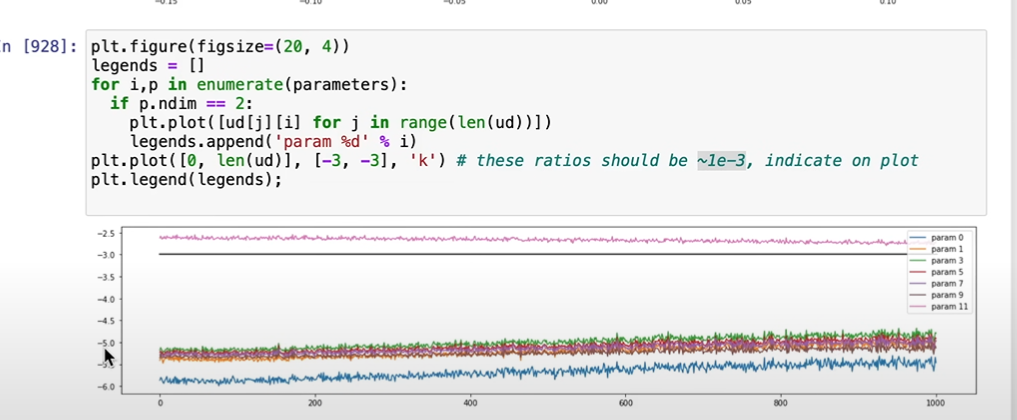

- size of update give way to smal value as shown above

###  viz #4: update: data ratio over time

- added batchNorm1D
- 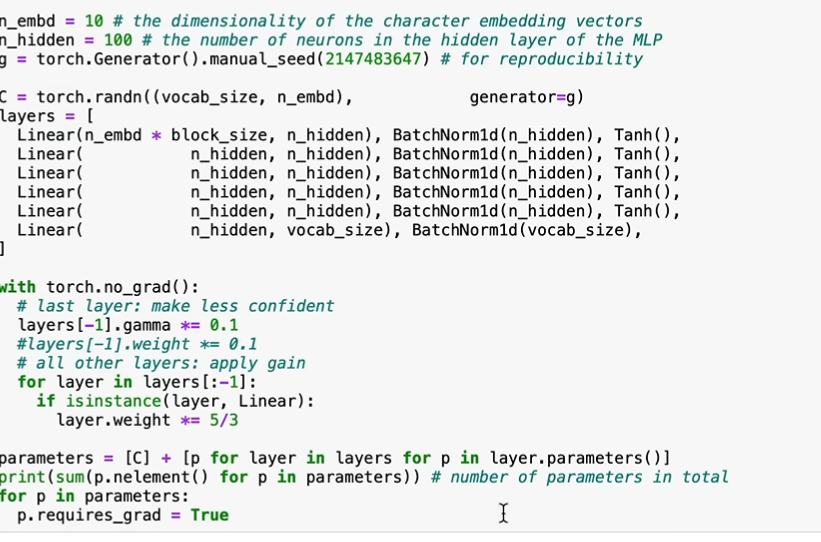

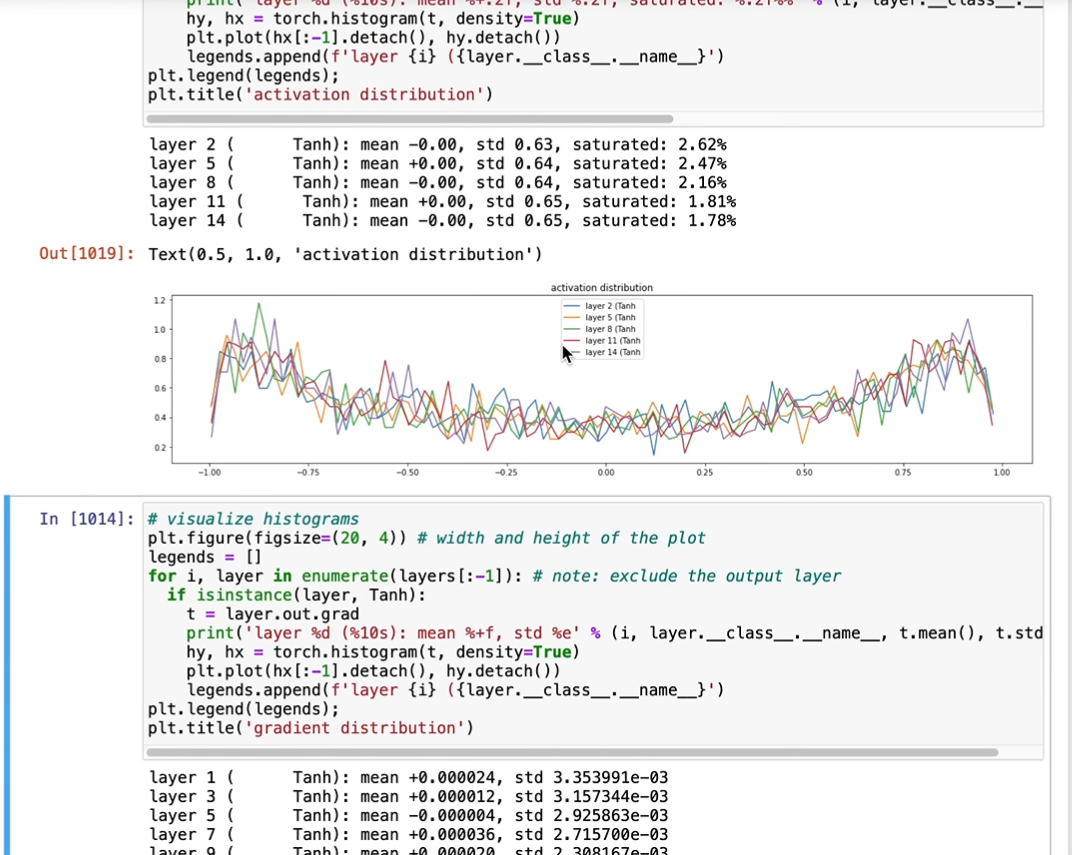

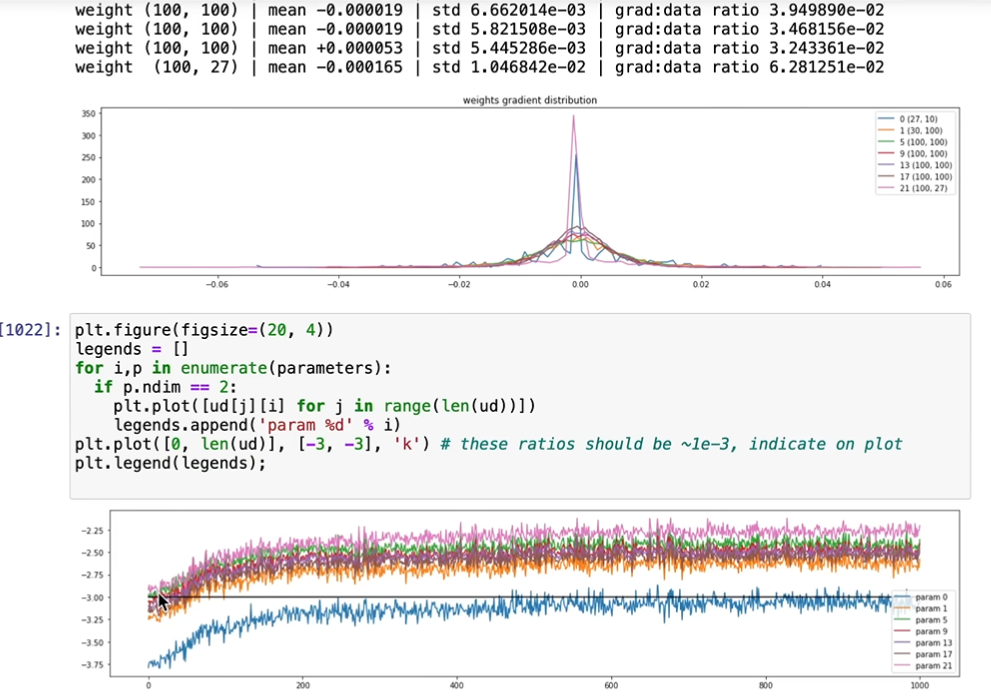

- if i change wieght change from 5/3 to 0.1, all will be say except update will be different so lr need to find proper
- if we remove fan-in still it will look somewhat good again lr can be 1.0

### bringing back batchnorm, looking at the visualizations

### summary of the lecture for real this time

Batch Normalization and Neural Network Training Diagnostics

### Key Concepts Introduced

1. **Batch Normalization**:
   - Stabilizes the training of deep networks by normalizing activations within mini-batches.
   - Helps maintain consistent activation distributions, improving learning dynamics.
   - Reduces sensitivity to initialization and allows the use of higher learning rates.

2. **Importance of Calibration**:
   - Proper calibration of weights, gains, and learning rates ensures well-behaved activations, gradients, and updates.
   - Miscalibrated networks show skewed activations, imbalanced learning rates across layers, and poor performance.

3. **Diagnostic Tools**:
   - **Monitoring**:
     - Activation distributions (standard deviation consistency across layers).
     - Gradient histograms.
     - Update-to-data ratio (`updates/grads`).
   - **Ideal Ratio**: Updates-to-data ratio should be approximately \(10^{-3}\) on a log scale.

4. **Robustness of Batch Normalization**:
   - Networks with batch normalization are less sensitive to weight initialization or scaling issues.
   - Learning rates may still need tuning to ensure optimal training dynamics.

---

### Practical Considerations

1. **Placement of BatchNorm**:
   - Typically placed between the linear layer and the activation function.
   - Alternative placements (e.g., after the activation function) yield comparable results.

2. **Fan-In Normalization**:
   - Not always necessary when using batch normalization, as it inherently adjusts for scaling issues.
   - Removing fan-in normalization may require retuning learning rates.

3. **Impact of Learning Rate**:
   - Changing gains or removing fan-in normalization impacts the scale of updates, necessitating learning rate adjustments.
   - Proper tuning ensures effective parameter updates and stable training.

---

### Limitations Addressed

1. **Performance Bottlenecks**:
   - Improvements with batch normalization may plateau when optimization is no longer the bottleneck (e.g., context length in language models).
   - Transitioning to more powerful architectures (e.g., RNNs, Transformers) is necessary to overcome data limitations.

2. **Unexplored Aspects**:
   - Detailed explanation of backward pass mechanics and how changes in gain affect gradients was deferred.
   - Initialization and backpropagation techniques are still active research areas.

---

## Takeaways

- Batch normalization significantly improves the stability and robustness of deep network training.
- Diagnostics such as activation and gradient analysis are crucial for identifying and addressing training issues.
- While batch normalization addresses many issues, tuning learning rates and other hyperparameters remains essential for optimal results.
- Ongoing research aims to further enhance initialization methods and training dynamics.
